In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Run for each Explainer

In [ ]:
import os
from collections import defaultdict

from tqdm import tqdm
from PIL import Image, ImageFilter

import torch
import numpy as np
import pandas as pd

from captum.attr import (
    IntegratedGradients,
    Saliency,
    DeepLift,
    Occlusion,
    LayerGradCam,
    GuidedGradCam,
    Deconvolution,
    GradientShap,
    DeepLiftShap,
    Lime,
    LayerAttribution,
)
from captum.metrics import sensitivity_max, infidelity

from skimage.segmentation import slic

from utils.utils import create_folder, load_config
from dataloaders.presets import PresetTransform
from models import *

def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.1, inputs.shape)).float().to(inputs.device)
    return noise, torch.clip(inputs - noise, 0, 1)

def rgb_to_gray_and_scale(x):
    x = np.asarray(x)
    # Shape must be in (H, W, C)
    x_combined = np.sum(x, axis=2)
    x_combined = (x_combined > 0) * x_combined

    sorted_vals = np.sort(np.abs(x_combined).flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id: int = np.where(cum_sums >= cum_sums[-1] * 0.01 * 98)[0][0]
    threshold = sorted_vals[threshold_id]

    attr_norm = x_combined / threshold
    
    return np.clip(attr_norm, 0, 1) # only positive for pain class

# --- Create superpixel feature mask for Captum ---
def make_feature_mask(img_tensor, n_segments=100):
    x = img_tensor.detach().cpu().squeeze(0)  # 3 x H x W
    x_np = x.numpy()
    x_np = (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-8)
    x_np = np.transpose(x_np, (1, 2, 0))  # H, W, 3

    seg = slic(x_np, n_segments=n_segments, compactness=10.0, sigma=0.0,
               start_label=0, channel_axis=2)

    seg_t = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)
    return seg_t, seg

# ------------------------------------------------------------------------------

device = 'cuda'
model_name = 'NCNN'
path_experiments = os.path.join('experiments', model_name)

# ------------------------------------------------------------------------------

def resolve_experiment(exp_name: str, device: torch.device):
    if "NCNN" in exp_name:
        model = NCNN().to(device)
        return {
            "model": model,
            "img_size": 120,
            "transform": PresetTransform("NCNN").transforms,
            "layer": model.merge_branch[0],
            "model_name": exp_name,
        }
    if "VGGFace" in exp_name:
        model = VGGFace().to(device)
        return {
            "model": model,
            "img_size": 224,
            "transform": PresetTransform("VGGFace").transforms,
            "layer": model.VGGFace.features.conv5_3,
            "model_name": exp_name,
        }
    if "ViT" in exp_name:
        model = ViT().to(device)
        return {
            "model": model,
            "img_size": 224,
            "transform": PresetTransform("ViT").transforms,
            "layer": model.ViT.conv_proj,
            "model_name": exp_name,
        }
    return None


def ensure_feature_mask(ctx: dict, n_segments: int = 100):
    if "feature_mask" not in ctx:
        mask, _ = make_feature_mask(ctx["input"], n_segments=n_segments)
        ctx["feature_mask"] = mask.to(ctx["device"]).contiguous()
    return ctx["feature_mask"]


# explainer catalogue ----------------------------------------------------------

EXPLAINER_SPECS = [
    (
        "IntegratedGradients",
        {
            "factory": lambda model, layer: IntegratedGradients(model),
            "prepare": lambda ctx: {"attribute": {"internal_batch_size": 10}},
        },
    ),
    (
        "Saliency",
        {
            "factory": lambda model, layer: Saliency(model),
        },
    ),
    (
        "DeepLift",
        {
            "factory": lambda model, layer: DeepLift(model),
            "prepare": lambda ctx: {"attribute": {"baselines": ctx["blurred"]}},
        },
    ),
    (
        "Occlusion",
        {
            "factory": lambda model, layer: Occlusion(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "sliding_window_shapes": (3, 20, 20),
                    "strides": (3, 10, 10),
                }
            },
        },
    ),
    (
        "GradCAM",
        {
            "factory": lambda model, layer: LayerGradCam(model, layer),
            "postprocess": lambda attr, ctx: LayerAttribution.interpolate(
                attr, ctx["target_shape"], interpolate_mode="bilinear"
            ).repeat(1, 3, 1, 1),
        },
    ),
    (
        "GuidedGradCAM",
        {
            "factory": lambda model, layer: GuidedGradCam(model, layer),
        },
    ),
    (
        "Deconvolution",
        {
            "factory": lambda model, layer: Deconvolution(model),
        },
    ),
    (
        "GradientShap",
        {
            "factory": lambda model, layer: GradientShap(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "baselines": torch.zeros_like(ctx["input"]),
                    "n_samples": 5,
                    "stdevs": 0.0,
                }
            },
        },
    ),
    (
        "DeepLiftShap",
        {
            "factory": lambda model, layer: DeepLiftShap(model),
            "prepare": lambda ctx: {
                "attribute": {"baselines": ctx["blurred"].repeat(5, 1, 1, 1)}
            },
        },
    ),
    (
        "Lime",
        {
            "factory": lambda model, layer: Lime(model),
            "prepare": lambda ctx: {
                "attribute": {
                    "baselines": torch.zeros_like(ctx["input"]),
                    "feature_mask": ensure_feature_mask(ctx),
                    "n_samples": 500,
                    "perturbations_per_eval": 64,
                    "show_progress": False,
                }
            },
        },
    ),
]


# main pipeline ----------------------------------------------------------------

all_data = defaultdict(list)

for exp in os.listdir(path_experiments):
    if any(ext in exp for ext in (".pkl", "masks", ".png", ".pdf")):
        continue

    experiment_cfg = resolve_experiment(exp, device)
    if experiment_cfg is None:
        continue

    model = experiment_cfg["model"]
    img_size = experiment_cfg["img_size"]
    transform = experiment_cfg["transform"]
    layer = experiment_cfg["layer"]

    path_model = os.path.join(path_experiments, exp, "Model", "best_model.pt")
    path_yaml = os.path.join(path_experiments, exp, "Model", "config.yaml")
    config = load_config(path_yaml)
    test_path = config["path_test"]

    state_dict = torch.load(path_model, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    explainers = {name: spec["factory"](model, layer) for name, spec in EXPLAINER_SPECS}

    image_files = [f for f in os.listdir(test_path) if f.lower().endswith(".jpg")]
    for image_file in tqdm(image_files):
        full_img_path = os.path.join(test_path, image_file)

        img_rgb = Image.open(full_img_path).convert("RGB")
        img_rgb = img_rgb.resize((img_size, img_size))
        img_name = os.path.splitext(image_file)[0]
        label = 1 if img_name.split("_")[3] == "pain" else 0

        if "VGGFace" in exp:
            img_input = Image.fromarray(np.array(img_rgb)[:, :, ::-1])
        else:
            img_input = img_rgb

        blurred_image = img_input.filter(ImageFilter.GaussianBlur(radius=5))

        transformed = transform(img_input)
        transformed_blurred = transform(blurred_image)

        base_input = transformed.unsqueeze(0).to(device)
        base_blurred = transformed_blurred.unsqueeze(0).to(device)

        ctx_base = {
            "device": device,
            "target_shape": (img_size, img_size),
            "input_base": base_input,
            "blurred": base_blurred,
        }

        for XAI_name, spec in EXPLAINER_SPECS:
            explainer = explainers[XAI_name]

            method_ctx = dict(ctx_base)
            method_ctx["input"] = (
                ctx_base["input_base"].clone().detach().requires_grad_(True)
            )

            if XAI_name == "Lime" or XAI_name == "DeepLift":
                method_ctx["input"] = (
                    ctx_base["input_base"].clone().detach().requires_grad_(True).contiguous()
            )

            spec_kwargs = spec.get("prepare", lambda ctx: {})(method_ctx)
            attr_kwargs = spec_kwargs.get("attribute", {})
            sensitivity_kwargs = dict(attr_kwargs)
            sensitivity_kwargs.update(spec_kwargs.get("sensitivity", {}))
            infidelity_kwargs = spec_kwargs.get("infidelity", {}).copy()
            infidelity_kwargs.setdefault("normalize", True)

            attributions = explainer.attribute(method_ctx["input"], **attr_kwargs)

            if "postprocess" in spec:
                attributions = spec["postprocess"](attributions, method_ctx)

            sens = sensitivity_max(
                explainer.attribute, method_ctx["input"], **sensitivity_kwargs
            )
            infid = infidelity(
                model,
                perturb_fn,
                method_ctx["input"],
                attributions,
                **infidelity_kwargs,
            )

            attributions_np = (
                attributions.squeeze(0)
                .detach()
                .cpu()
                .numpy()
                .transpose(1, 2, 0)
            )
            attributions_normalized = rgb_to_gray_and_scale(attributions_np)

            output_dir = os.path.join("RGU", model_name, XAI_name)
            create_folder(output_dir)
            output_path = os.path.join(output_dir, f"{img_name}.npz")
            np.savez_compressed(output_path, mask=attributions_normalized)

            all_data["img_path"].append(full_img_path)
            all_data["fold"].append(os.path.basename(os.path.dirname(test_path)))
            all_data["label"].append(label)
            all_data["sensitivity"].append(float(sens))
            all_data["infidelity"].append(float(infid))
            all_data["mask_path"].append(output_path)

            with torch.no_grad():
                probs = model.predict(ctx_base["input_base"])
            pred = (probs >= 0.5).int()
            all_data["probability"].append(float(probs))
            all_data["prediction"].append(int(pred))
            all_data["XAI_name"].append(XAI_name)

dataframe = pd.DataFrame(all_data)
create_folder(os.path.join("RGU", model_name))
dataframe.to_csv(os.path.join("RGU", model_name, "explainers.csv"), index=False)

# XAI Analysis


## Sensitivity and Infidelity

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path_NCNN = "RGU\\NCNN\\explainers.csv"
path_VGG = "RGU\\VGGFace\\explainers.csv"
path_ViT = "RGU\\ViT_B_32\\explainers.csv"

In [3]:
NCNN_df = pd.read_csv(path_NCNN)
NCNN_df['correct'] = NCNN_df['label'] == NCNN_df['prediction']
NCNN_df['model'] = "NCNN"

VGG_df = pd.read_csv(path_VGG)
VGG_df['correct'] = VGG_df['label'] == VGG_df['prediction']
VGG_df['model'] = "VGGFace"

ViT_df = pd.read_csv(path_ViT)
ViT_df['correct'] = ViT_df['label'] == ViT_df['prediction']
ViT_df['model'] = "ViT"

In [4]:
NCNN_df

img_path  fold  label   
0     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0  \
1     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
2     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
3     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
4     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
...                                                ...   ...    ...   
5205    Datasets/Folds/5/Test/ID277_iCOPE_S25_pain.jpg     5      1   
5206    Datasets/Folds/5/Test/ID277_iCOPE_S25_pain.jpg     5      1   
5207    Datasets/Folds/5/Test/ID277_iCOPE_S25_pain.jpg     5      1   
5208    Datasets/Folds/5/Test/ID277_iCOPE_S25_pain.jpg     5      1   
5209    Datasets/Folds/5/Test/ID277_iCOPE_S25_pain.jpg     5      1   

      sensitivity  infidelity   
0        0.899501   34.192320  \
1        0.705195   31.678720   
2        1.289413   29.185413   
3        0.030694   34.374020   
4        0.802177   24.418251   
...           ...         ...   
5205     0.844638    0.020525   
5206     0.725439    0.014596   
5207     0.656697    0.038627   
5208     1.121128    0.021924   
5209     0.437604    0.053819   

                                              mask_path  probability   
0     RGU/NCNN/IntegratedGradients/ID224_iCOPE_S19_n...     0.033350  \
1          RGU/NCNN/Saliency/ID224_iCOPE_S19_nopain.npz     0.033350   
2          RGU/NCNN/DeepLift/ID224_iCOPE_S19_nopain.npz     0.033350   
3         RGU/NCNN/Occlusion/ID224_iCOPE_S19_nopain.npz     0.033350   
4           RGU/NCNN/GradCAM/ID224_iCOPE_S19_nopain.npz     0.033350   
...                                                 ...          ...   
5205    RGU/NCNN/GuidedGradCAM/ID277_iCOPE_S25_pain.npz     0.980953   
5206    RGU/NCNN/Deconvolution/ID277_iCOPE_S25_pain.npz     0.980953   
5207     RGU/NCNN/GradientShap/ID277_iCOPE_S25_pain.npz     0.980953   
5208     RGU/NCNN/DeepLiftShap/ID277_iCOPE_S25_pain.npz     0.980953   
5209             RGU/NCNN/Lime/ID277_iCOPE_S25_pain.npz     0.980953   

      prediction             XAI_name  correct model  
0              0  IntegratedGradients     True  NCNN  
1              0             Saliency     True  NCNN  
2              0             DeepLift     True  NCNN  
3              0            Occlusion     True  NCNN  
4              0              GradCAM     True  NCNN  
...          ...                  ...      ...   ...  
5205           1        GuidedGradCAM     True  NCNN  
5206           1        Deconvolution     True  NCNN  
5207           1         GradientShap     True  NCNN  
5208           1         DeepLiftShap     True  NCNN  
5209           1                 Lime     True  NCNN  

[5210 rows x 11 columns]

## NCNN

### All


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

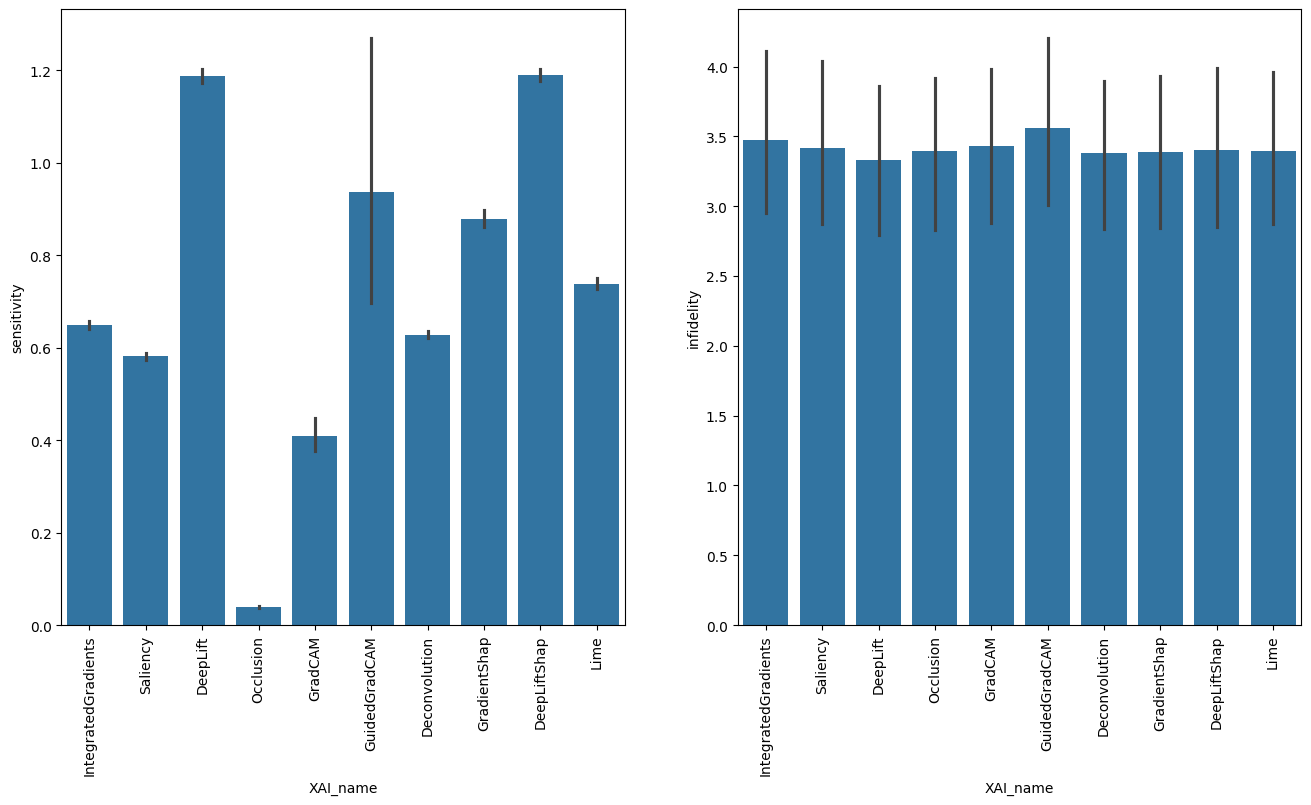

In [5]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=NCNN_df, y='sensitivity', x='XAI_name')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=NCNN_df, y='infidelity', x='XAI_name')
plt.xticks(rotation=90)

### By label

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

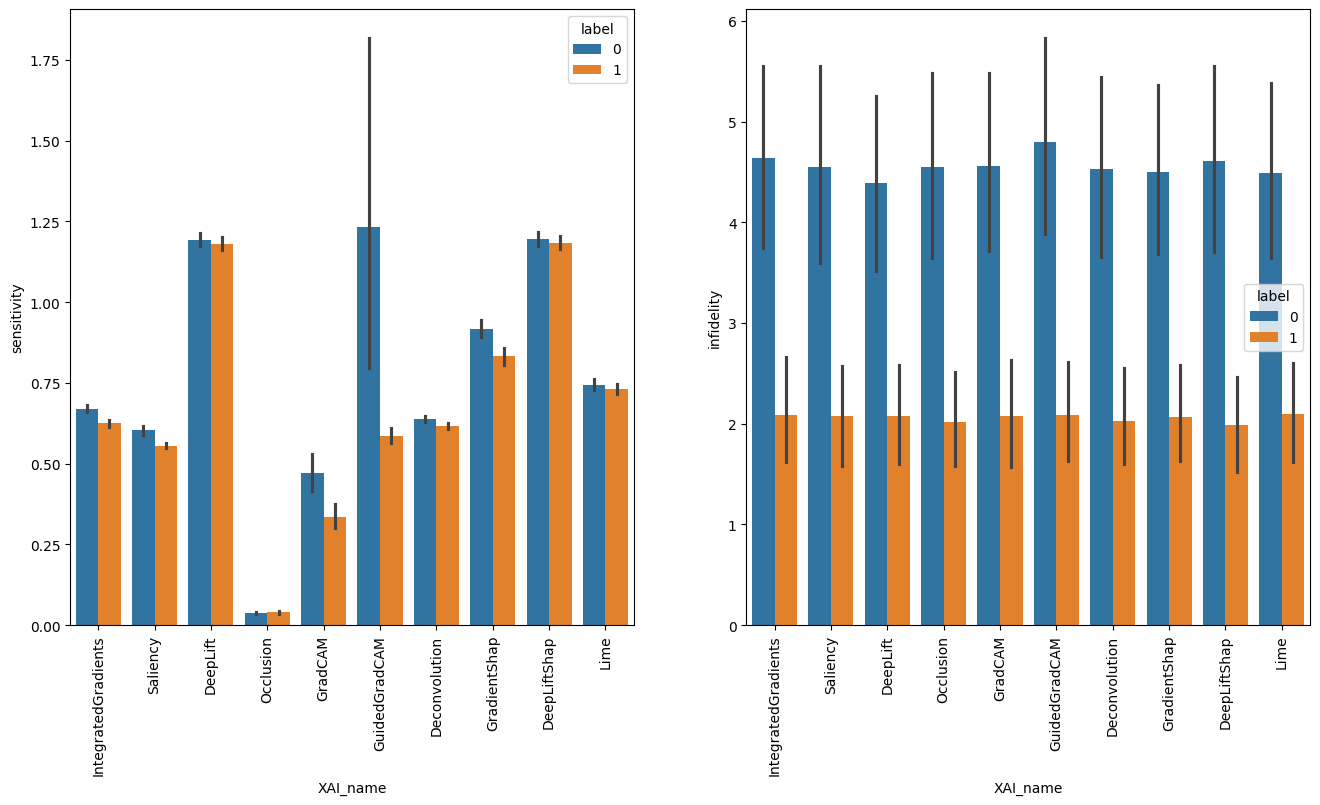

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=NCNN_df, y='sensitivity', x='XAI_name', hue='label')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=NCNN_df, y='infidelity', x='XAI_name', hue='label')
plt.xticks(rotation=90)


### By correct prediction

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

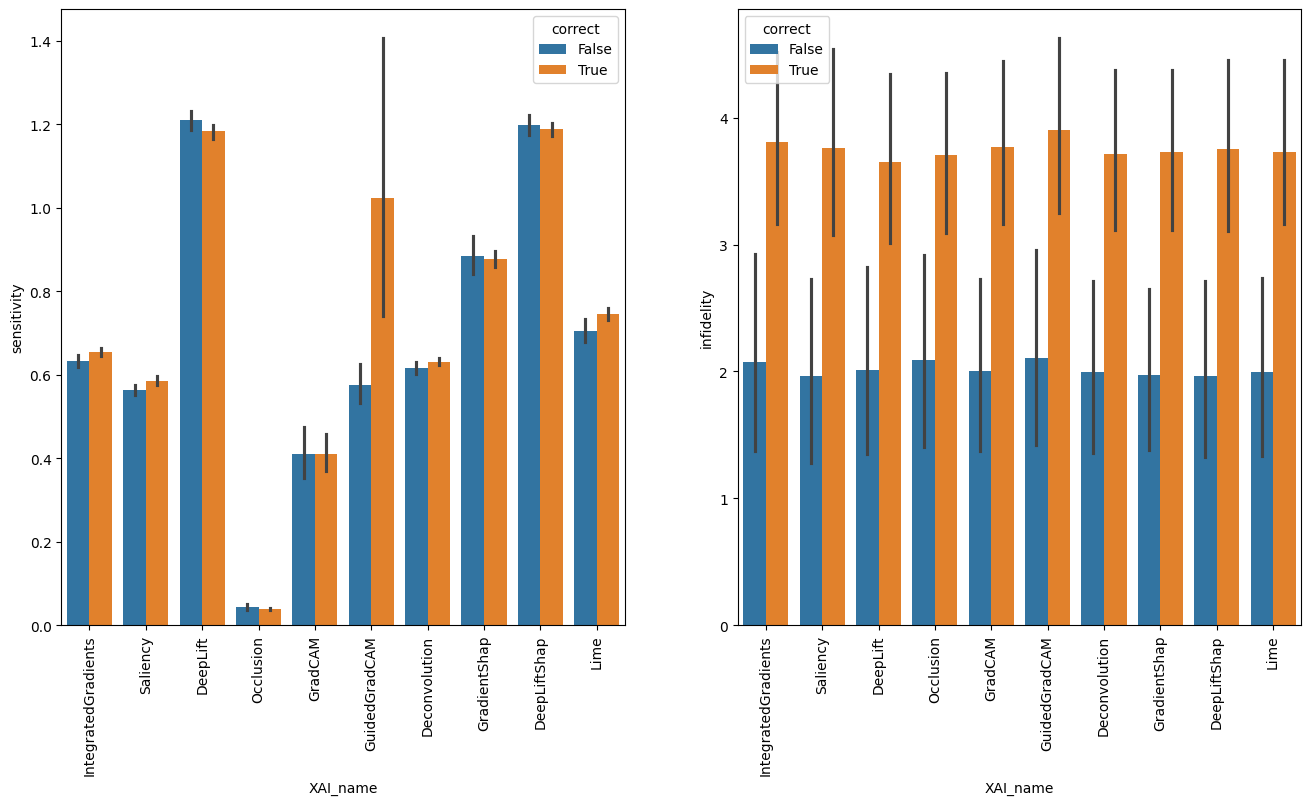

In [7]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=NCNN_df, y='sensitivity', x='XAI_name', hue='correct')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=NCNN_df, y='infidelity', x='XAI_name', hue='correct')
plt.xticks(rotation=90)


## VGG-Face

### All

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

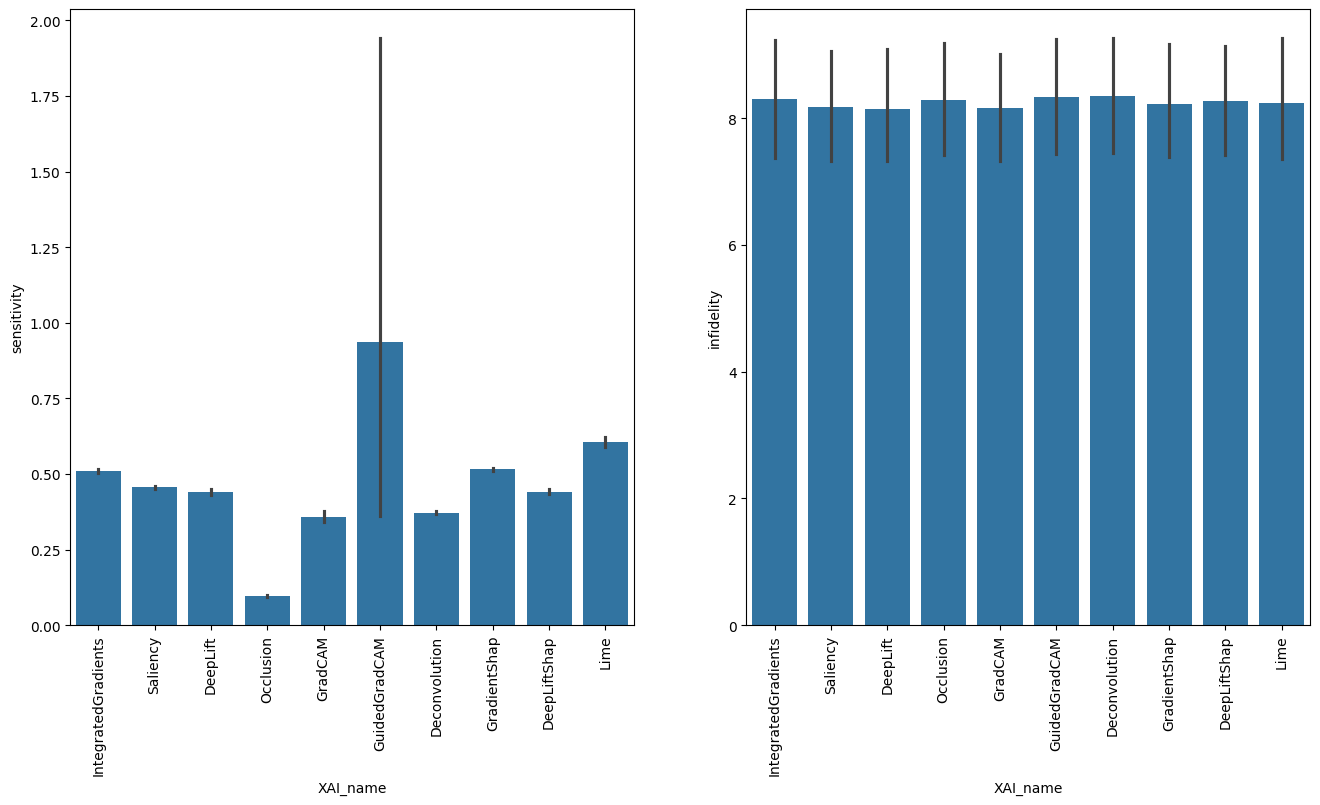

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=VGG_df, y='sensitivity', x='XAI_name')
plt.xticks(rotation=90)
plt.subplot(122)
sns.barplot(data=VGG_df, y='infidelity', x='XAI_name')
plt.xticks(rotation=90)

### By label

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

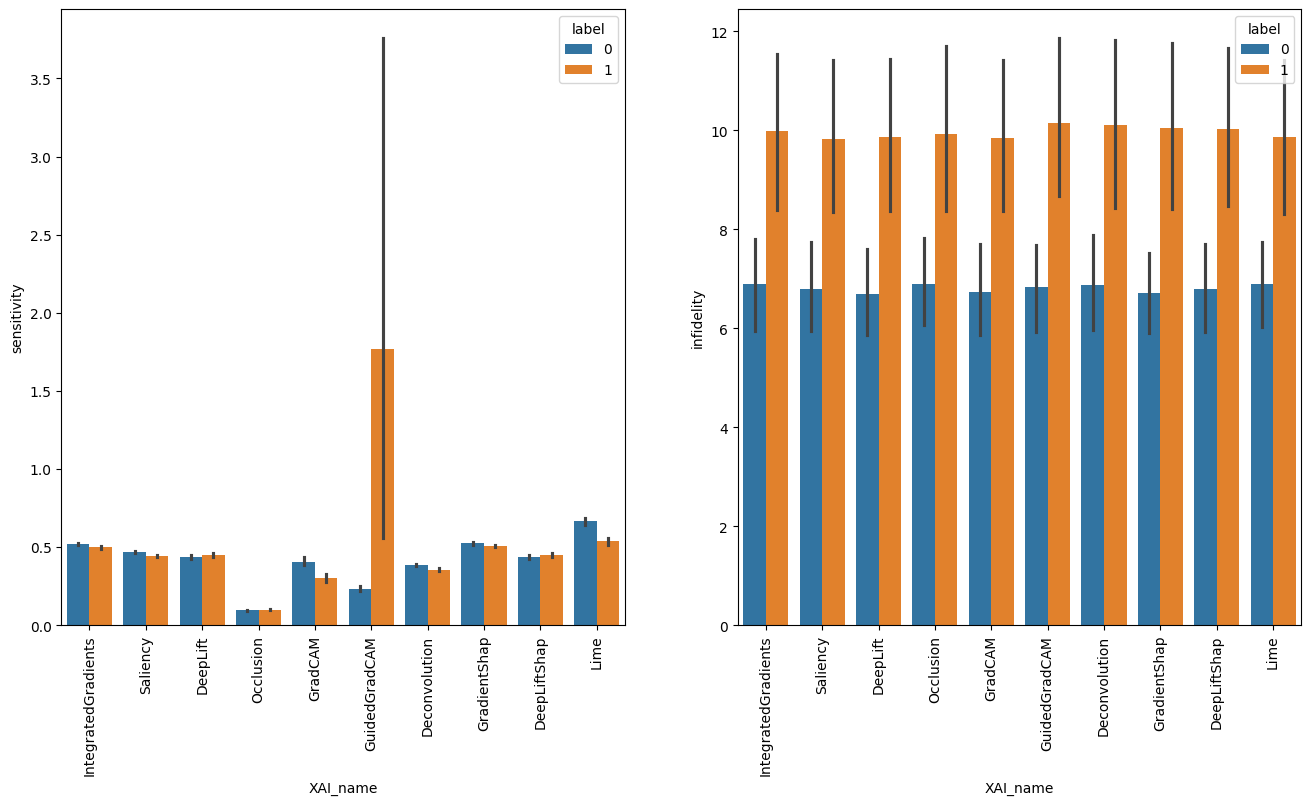

In [9]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=VGG_df, y='sensitivity', x='XAI_name', hue='label')
plt.xticks(rotation=90)
plt.subplot(122)
sns.barplot(data=VGG_df, y='infidelity', x='XAI_name', hue='label')
plt.xticks(rotation=90)


### By correct prediction

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

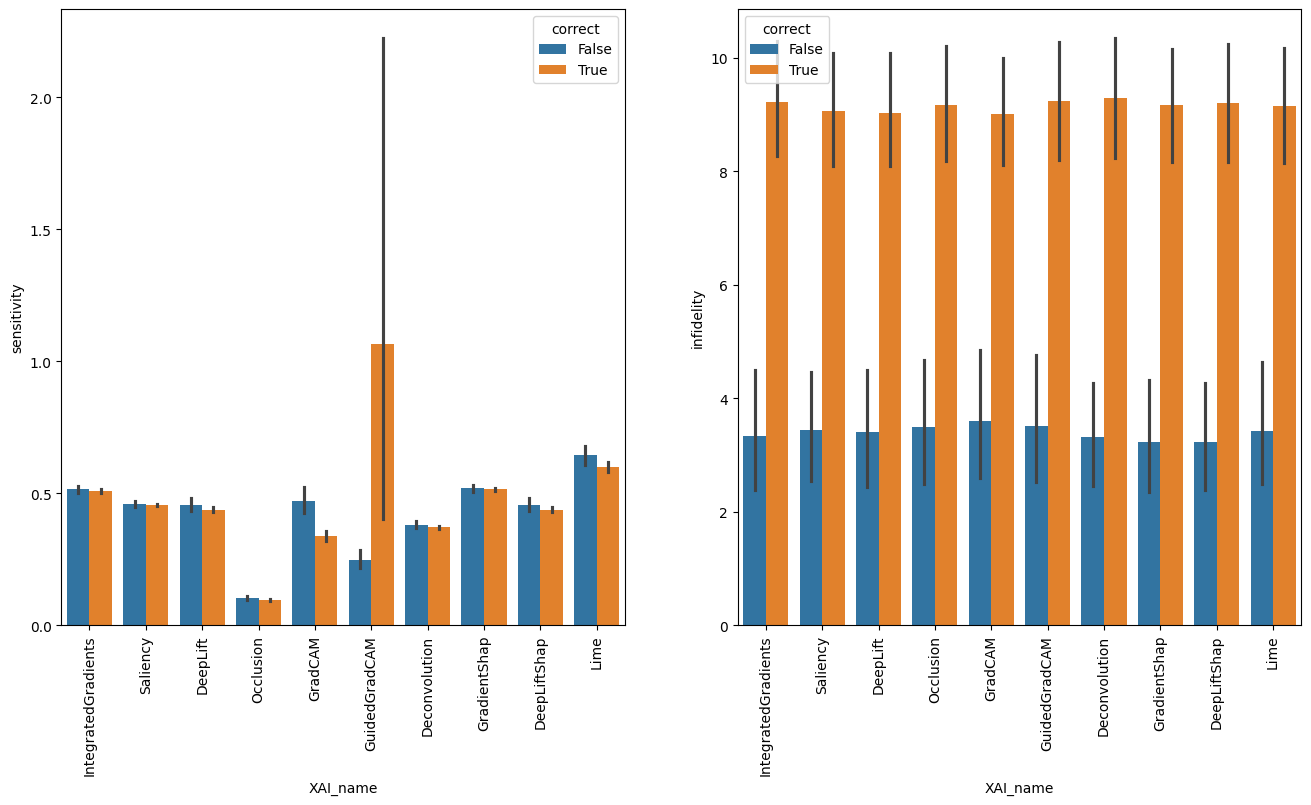

In [32]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=VGG_df, y='sensitivity', x='XAI_name', hue='correct')
plt.xticks(rotation=90)
plt.subplot(122)
sns.barplot(data=VGG_df, y='infidelity', x='XAI_name', hue='correct')
plt.xticks(rotation=90)


## ViT

### All

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

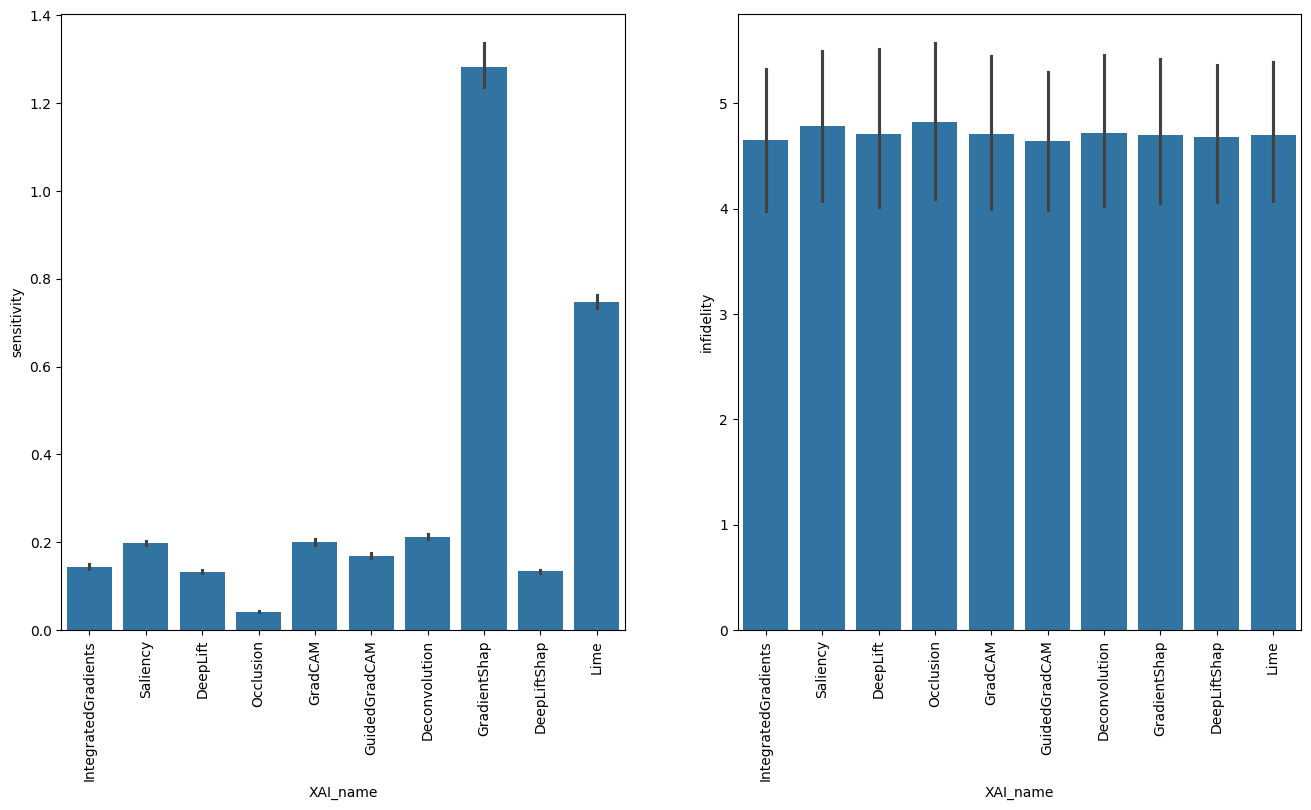

In [41]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=ViT_df, y='sensitivity', x='XAI_name')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=ViT_df, y='infidelity', x='XAI_name')
plt.xticks(rotation=90)

### By label

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

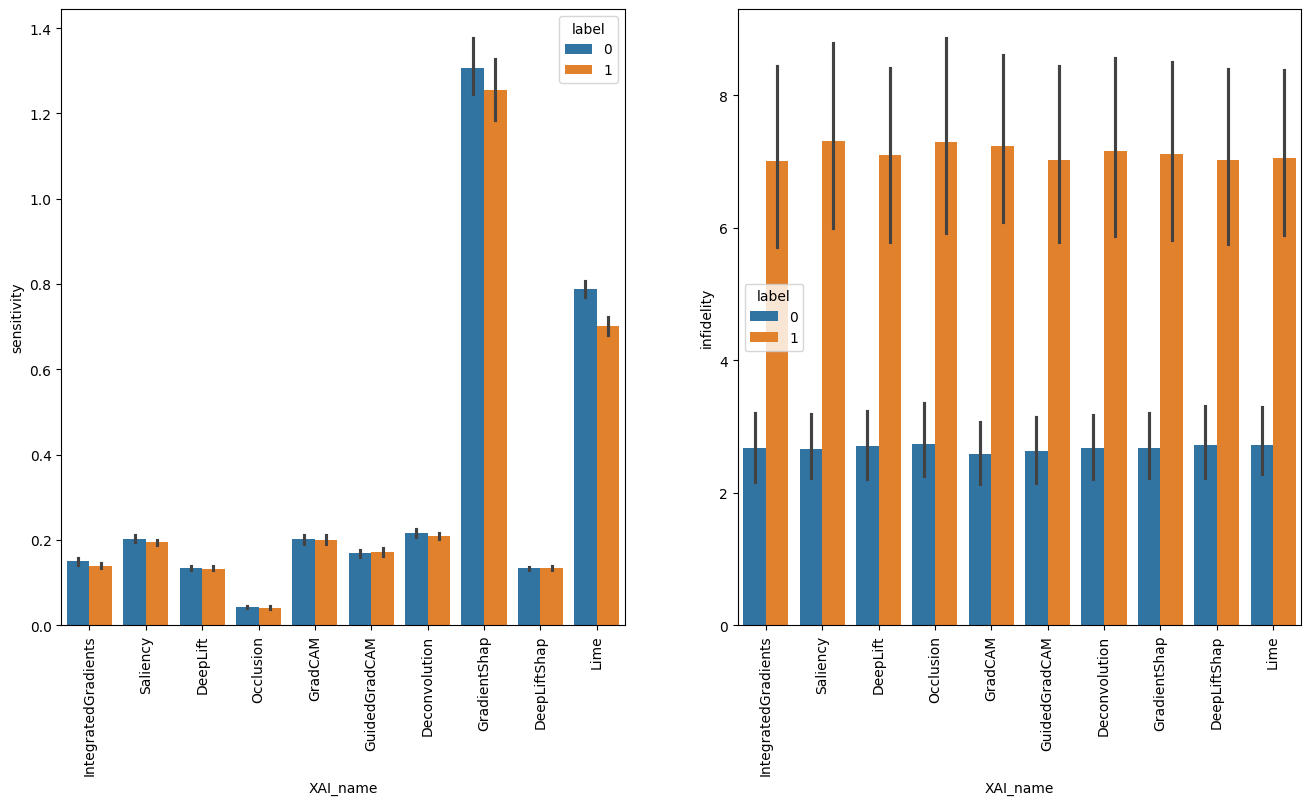

In [33]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=ViT_df, y='sensitivity', x='XAI_name', hue='label')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=ViT_df, y='infidelity', x='XAI_name', hue='label')
plt.xticks(rotation=90)

### By correct prediction

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

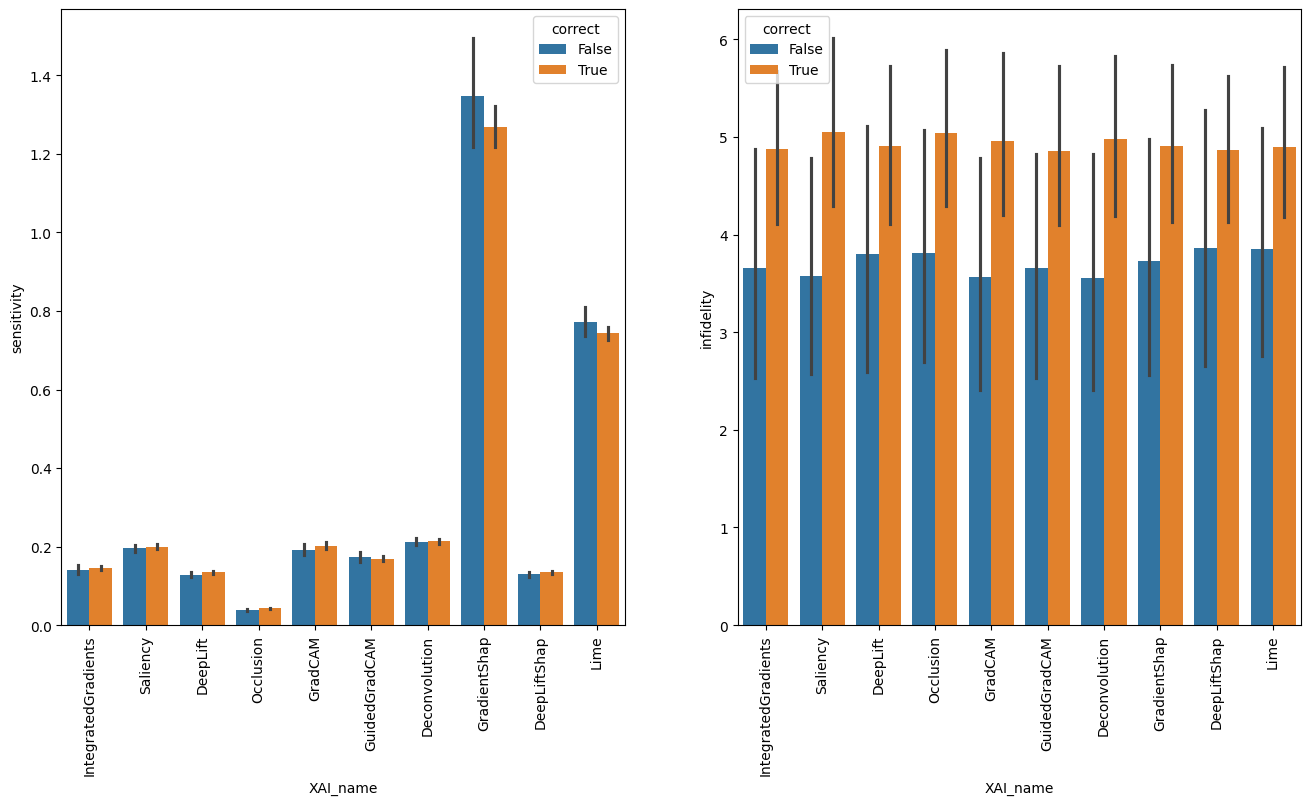

In [34]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=ViT_df, y='sensitivity', x='XAI_name', hue='correct')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=ViT_df, y='infidelity', x='XAI_name', hue='correct')
plt.xticks(rotation=90)

## Combined

In [11]:
combined_df = pd.concat([NCNN_df, VGG_df, ViT_df])

In [12]:
combined_df

img_path  fold  label   
0     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0  \
1     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
2     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
3     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
4     Datasets/Folds/6/Test/ID224_iCOPE_S19_nopain.jpg     6      0   
...                                                ...   ...    ...   
5205  Datasets/Folds/4/Test/ID417_UNIFESP_S38_pain.jpg     4      1   
5206  Datasets/Folds/4/Test/ID417_UNIFESP_S38_pain.jpg     4      1   
5207  Datasets/Folds/4/Test/ID417_UNIFESP_S38_pain.jpg     4      1   
5208  Datasets/Folds/4/Test/ID417_UNIFESP_S38_pain.jpg     4      1   
5209  Datasets/Folds/4/Test/ID417_UNIFESP_S38_pain.jpg     4      1   

      sensitivity  infidelity   
0        0.899501   34.192320  \
1        0.705195   31.678720   
2        1.289413   29.185413   
3        0.030694   34.374020   
4        0.802177   24.418251   
...           ...         ...   
5205     0.131219    0.272346   
5206     0.134377    0.184456   
5207     0.948526    0.179710   
5208     0.095260    0.294043   
5209     0.815908    0.281150   

                                              mask_path  probability   
0     RGU/NCNN/IntegratedGradients/ID224_iCOPE_S19_n...     0.033350  \
1          RGU/NCNN/Saliency/ID224_iCOPE_S19_nopain.npz     0.033350   
2          RGU/NCNN/DeepLift/ID224_iCOPE_S19_nopain.npz     0.033350   
3         RGU/NCNN/Occlusion/ID224_iCOPE_S19_nopain.npz     0.033350   
4           RGU/NCNN/GradCAM/ID224_iCOPE_S19_nopain.npz     0.033350   
...                                                 ...          ...   
5205  RGU/ViT_B_32/GuidedGradCAM/ID417_UNIFESP_S38_p...     0.068296   
5206  RGU/ViT_B_32/Deconvolution/ID417_UNIFESP_S38_p...     0.068296   
5207  RGU/ViT_B_32/GradientShap/ID417_UNIFESP_S38_pa...     0.068296   
5208  RGU/ViT_B_32/DeepLiftShap/ID417_UNIFESP_S38_pa...     0.068296   
5209       RGU/ViT_B_32/Lime/ID417_UNIFESP_S38_pain.npz     0.068296   

      prediction             XAI_name  correct model  
0              0  IntegratedGradients     True  NCNN  
1              0             Saliency     True  NCNN  
2              0             DeepLift     True  NCNN  
3              0            Occlusion     True  NCNN  
4              0              GradCAM     True  NCNN  
...          ...                  ...      ...   ...  
5205           0        GuidedGradCAM    False   ViT  
5206           0        Deconvolution    False   ViT  
5207           0         GradientShap    False   ViT  
5208           0         DeepLiftShap    False   ViT  
5209           0                 Lime    False   ViT  

[15630 rows x 11 columns]

In [14]:
combined_df.groupby(['model', 'XAI_name'])['infidelity'].median()

model    XAI_name           
NCNN     Deconvolution          0.852218
         DeepLift               0.867409
         DeepLiftShap           0.855435
         GradCAM                0.857337
         GradientShap           0.837240
         GuidedGradCAM          0.859275
         IntegratedGradients    0.856528
         Lime                   0.833545
         Occlusion              0.915083
         Saliency               0.837297
VGGFace  Deconvolution          4.496692
         DeepLift               4.383066
         DeepLiftShap           4.564531
         GradCAM                4.459712
         GradientShap           4.396743
         GuidedGradCAM          4.647072
         IntegratedGradients    4.200293
         Lime                   4.437522
         Occlusion              4.511008
         Saliency               4.426132
ViT      Deconvolution          1.703573
         DeepLift               1.653038
         DeepLiftShap           1.718461
         GradCAM            

In [ ]:
import pandas as pd

# Assuming your dataframe is named df

# 1. Group by model and XAI_name, calculate mean sensitivity and infidelity
metrics_summary = (
    combined_df.groupby(["model", "XAI_name"])
      .agg({
          "sensitivity": "mean",
          "infidelity": "mean"
      })
      .reset_index()
)

print("Metrics summary per model and explainer:")
print(metrics_summary)

# 2. Find the best explainer (lowest infidelity and sensitivity) for each model
best_explainers_infidelity = (
    metrics_summary.loc[metrics_summary.groupby("model")["infidelity"].idxmin()]
    .reset_index(drop=True)
)

best_explainers_sensitivity = (
    metrics_summary.loc[metrics_summary.groupby("model")["sensitivity"].idxmin()]
    .reset_index(drop=True)
)

worst_explainers_infidelity = (
    metrics_summary.loc[metrics_summary.groupby("model")["infidelity"].idxmax()]
    .reset_index(drop=True)
)

worst_explainers_sensitivity = (
    metrics_summary.loc[metrics_summary.groupby("model")["sensitivity"].idxmax()]
    .reset_index(drop=True)
)

print("\nBest explainers per model (lowest infidelity):")
print(best_explainers_infidelity)

print("\nBest explainers per model (lowest sensitivity):")
print(best_explainers_sensitivity)

print("\nWorst explainers per model (highest infidelity):")
print(worst_explainers_infidelity)

print("\nWorst explainers per model (highest sensitivity):")
print(worst_explainers_sensitivity)

# 3. (Optional) Combine to see if one explainer is best for both metrics
best_overall = (
    metrics_summary
    .assign(rank_infidelity=metrics_summary.groupby("model")["infidelity"].rank(method="min"),
            rank_sensitivity=metrics_summary.groupby("model")["sensitivity"].rank(method="min"))
    .assign(total_rank=lambda x: x["rank_infidelity"] + x["rank_sensitivity"])
)

best_combined = best_overall.loc[best_overall.groupby("model")["total_rank"].idxmin()]

print("\nBest overall explainers (considering both infidelity + sensitivity):")
print(best_combined)


Metrics summary per model and explainer:
      model             XAI_name  sensitivity  infidelity
0      NCNN        Deconvolution     0.085243    6.352588
1      NCNN             DeepLift     0.168350    6.296695
2      NCNN         DeepLiftShap     0.165698    6.578817
3      NCNN              GradCAM     0.423828    6.427531
4      NCNN         GradientShap     0.218422    6.430954
5      NCNN        GuidedGradCAM     3.377747    6.928478
6      NCNN  IntegratedGradients     0.092086    6.682603
7      NCNN                 Lime     0.141934    6.315481
8      NCNN            Occlusion     0.028471    6.430012
9      NCNN             Saliency     0.101939    6.590722
10  VGGFace        Deconvolution     0.066081   10.469651
11  VGGFace             DeepLift     0.112564   10.273391
12  VGGFace         DeepLiftShap     0.112965   10.350192
13  VGGFace              GradCAM     0.220205   10.180894
14  VGGFace         GradientShap     0.067071   10.366763
15  VGGFace        GuidedGradCA

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'IntegratedGradients'),
  Text(1, 0, 'Saliency'),
  Text(2, 0, 'DeepLift'),
  Text(3, 0, 'Occlusion'),
  Text(4, 0, 'GradCAM'),
  Text(5, 0, 'GuidedGradCAM'),
  Text(6, 0, 'Deconvolution'),
  Text(7, 0, 'GradientShap'),
  Text(8, 0, 'DeepLiftShap'),
  Text(9, 0, 'Lime')])

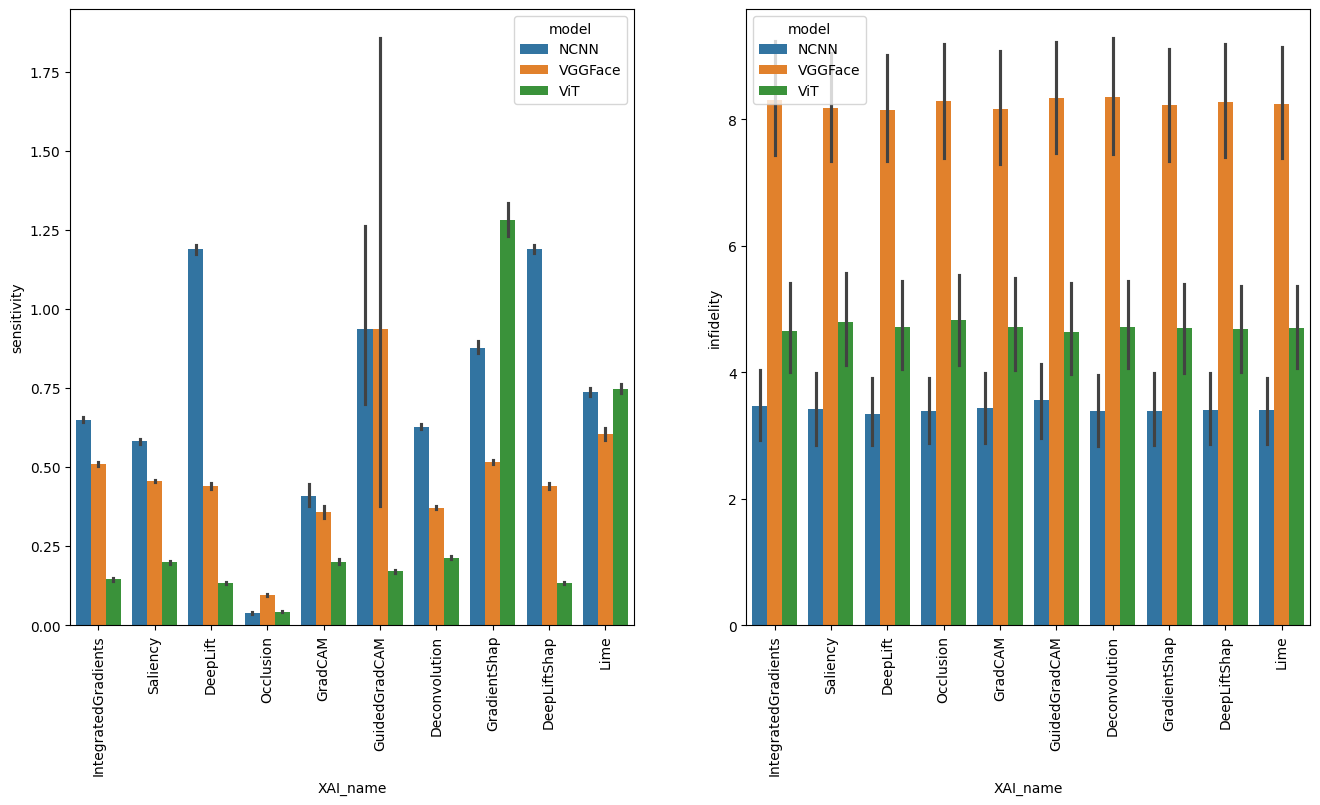

In [54]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.barplot(data=combined_df, y='sensitivity', x='XAI_name', hue='model')
plt.xticks(rotation=90)

plt.subplot(122)
sns.barplot(data=combined_df, y='infidelity', x='XAI_name', hue='model')
plt.xticks(rotation=90)

C:\Users\leona\AppData\Local\Temp\ipykernel_10232\1322613074.py:28: RuntimeWarning: All-NaN slice encountered
  m_min, m_max = np.nanmin(mask), np.nanmax(mask)


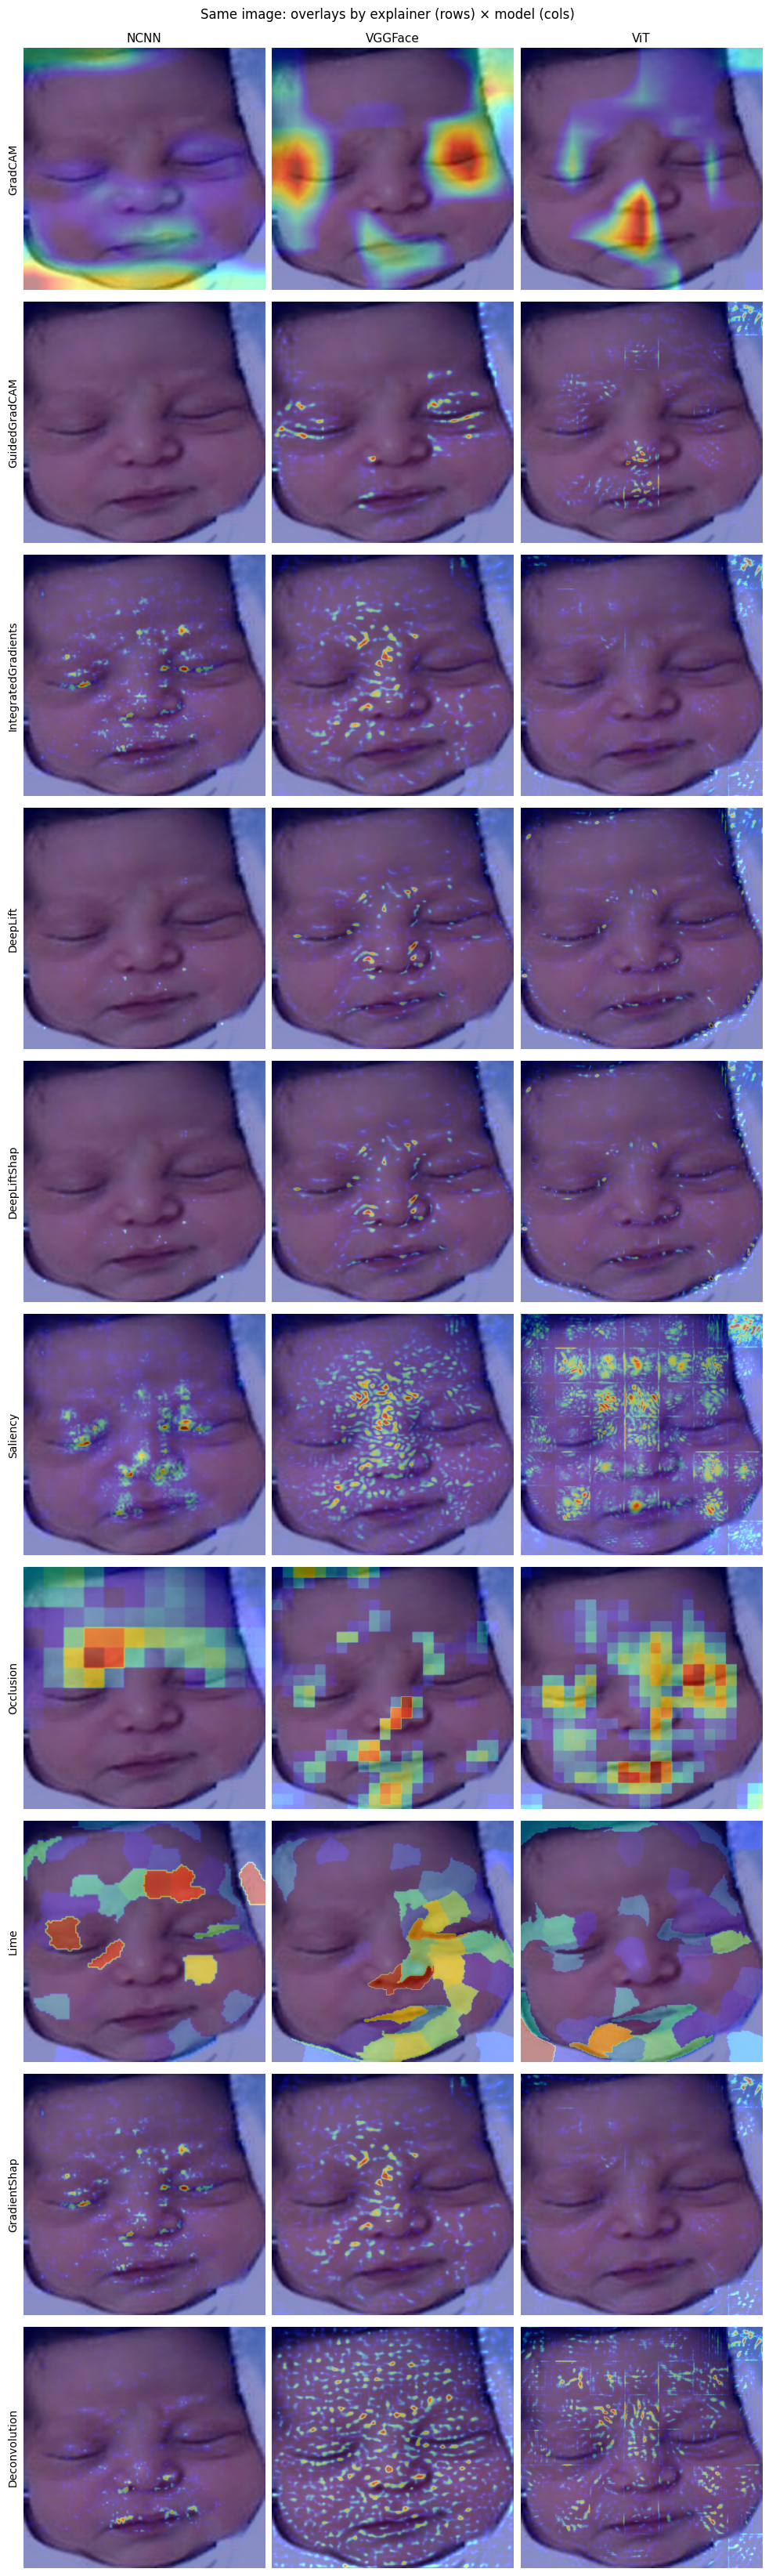

In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

def _load_mask(mask_path, target_size=None):
    """
    Load a mask from .npy or image file. Returns float32 array normalized to [0, 1].
    If target_size is provided, resizes mask to (W, H) of target image.
    """
    if mask_path is None or not os.path.exists(mask_path):
        return None

    ext = os.path.splitext(mask_path)[1].lower()
    try:
        if ext == ".npz":
            mask = np.load(mask_path)['mask']
        else:
            # Load as grayscale
            m = Image.open(mask_path).convert("L")
            mask = np.array(m)
    except Exception:
        return None

    mask = mask.astype(np.float32)
    # If constant mask, avoid division by zero
    m_min, m_max = np.nanmin(mask), np.nanmax(mask)
    if m_max > m_min:
        mask = (mask - m_min) / (m_max - m_min)
    else:
        mask = np.zeros_like(mask, dtype=np.float32)

    # Resize if needed
    if target_size is not None:
        W, H = target_size
        pil_mask = Image.fromarray((mask * 255).astype(np.uint8))
        pil_mask = pil_mask.resize((W, H), resample=Image.BILINEAR)
        mask = np.array(pil_mask).astype(np.float32) / 255.0

    return mask

def _load_image(img_path):
    """
    Load the base image as RGB uint8 array.
    """
    img = Image.open(img_path).convert("RGB")
    return np.array(img)

def plot_image_masks_grid(
    df: pd.DataFrame,
    image_selector: str,
    selector_by: str = "img_path",       # "img_path" or "basename"
    alpha=0.45,                          # overlay transparency
    share_scale=True,                    # force same vmin/vmax for all masks
    explainer_order=None,                # custom row order
    model_order=None,                    # custom column order
    suptitle=None
):
    """
    Build a grid: rows=explainers, columns=models, showing the same image with XAI mask overlay.
    image_selector: the string to select the image. If selector_by='img_path', matches exact path;
                    if 'basename', matches os.path.basename(img_path).
    """
    # --- Filter rows for the chosen image ---
    if selector_by == "img_path":
        df_img = df[df["img_path"] == image_selector].copy()
    elif selector_by == "basename":
        base = os.path.basename(image_selector)
        df_img = df[df["img_path"].apply(lambda p: os.path.basename(str(p)) == base)].copy()
    else:
        raise ValueError("selector_by must be 'img_path' or 'basename'")

    if df_img.empty:
        raise ValueError("No rows found for the selected image.")

    # --- Determine orders ---
    explainers = sorted(df_img["XAI_name"].unique()) if explainer_order is None else explainer_order
    models = sorted(df_img["model"].unique()) if model_order is None else model_order

    # Ensure uniqueness & keep only those present
    explainers = [e for e in explainers if e in df_img["XAI_name"].unique()]
    models = [m for m in models if m in df_img["model"].unique()]

    # --- Load the base image (take the first row's path) ---
    base_img_path = df_img.iloc[0]["img_path"]
    base_img_path = base_img_path.replace("/", "\\")
    
    img = _load_image(base_img_path)
    H, W = img.shape[:2]

    # --- Pre-compute mask scale if share_scale is True ---
    global_min, global_max = 0.0, 1.0  # masks are normalized by loader to [0,1]
    if share_scale:
        # If you want to enforce a broader dynamic range across all masks,
        # compute min/max over all masks before plotting (kept at [0,1] by default).
        pass

    # --- Create figure ---
    n_rows, n_cols = len(explainers), len(models)
    figsize = (3.3 * n_cols, 3.3 * n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)

    # For a single colorbar aligned to the grid, store one im handle
    im_for_cbar = None

    # --- Iterate grid ---
    for r, expl in enumerate(explainers):
        for c, mdl in enumerate(models):
            ax = axes[r, c]

            # locate row for (model, explainer)
            row = df_img[(df_img["model"] == mdl) & (df_img["XAI_name"] == expl)]
            ax.axis("off")

            # Show base image
            ax.imshow(img)

            if row.empty:
                # Missing pair
                ax.text(
                    0.5, 0.5,
                    "No mask",
                    ha="center", va="center", transform=ax.transAxes,
                    fontsize=10
                )
            else:
                mask_path = row.iloc[0]["mask_path"]
                mask_path = mask_path.replace("/","\\")
                mask = _load_mask(mask_path, target_size=(W, H))
                if mask is None:
                    ax.text(
                        0.5, 0.5,
                        "Mask load error",
                        ha="center", va="center", transform=ax.transAxes,
                        fontsize=10
                    )
                else:
                    # Overlay mask with transparency.
                    # (No explicit cmap set to comply with neutral styling preferences.)
                    im = ax.imshow(mask, alpha=alpha, vmin=global_min, vmax=global_max, cmap='jet')
                    if im_for_cbar is None:
                        im_for_cbar = im

            # Column titles (models)
            if r == 0:
                ax.set_title(str(mdl), fontsize=11, pad=6)

            # Row labels (explainers)
            if c == 0:
                ax.text(
                    -0.02, 0.5, str(expl),
                    rotation=90, va="center", ha="right", fontsize=10,
                    transform=ax.transAxes
                )

    if suptitle:
        fig.suptitle(suptitle, y=0.995, fontsize=12)

    plt.tight_layout()
    plt.show()


# -------------------------
# Example usage:
# -------------------------
plot_image_masks_grid(
     combined_df,
     image_selector='Datasets/Folds/4/Test/ID417_UNIFESP_S38_pain.jpg',  # or "IMG_0001.png"
     selector_by="img_path",  # or "basename"
     alpha=0.45,
     share_scale=True,
     explainer_order=["GradCAM", "GuidedGradCAM", "IntegratedGradients", "DeepLift", "DeepLiftShap", "Saliency", "Occlusion", "Lime", "GradientShap", "Deconvolution"],
     model_order=["NCNN", "VGGFace", "ViT"],
     suptitle="Same image: overlays by explainer (rows) × model (cols)"
)


## Agreement

In [ ]:
import numpy as np
from pathlib import Path
from itertools import combinations
import pandas as pd
import glob

def load_masks(xai_dirs, mask_key="mask"):
    """Return {sample_id: {method_name: bool_mask}} for every .npz in the folders."""
    samples = {}
    for xai_dir in map(Path, xai_dirs):
        method = xai_dir.name
        for npz_file in sorted(xai_dir.glob("*.npz")):
            with np.load(npz_file) as archive:
                if mask_key not in archive:
                    raise KeyError(f"{npz_file} missing '{mask_key}' array.")
                mask = archive[mask_key]
            samples.setdefault(npz_file.stem, {})[method] = mask
    return samples

# Function to classify pixels by importance
def get_top_k_pixels(importance_map, k_percent=10):

    # Flatten the map and sort the pixels by importance
    flat_map = importance_map.flatten()
    threshold_value = np.percentile(flat_map, 100 - k_percent)
    top_k_mask = importance_map >= threshold_value

    return top_k_mask.astype('int')

def feature_agreement(mask_1, mask_2):
    
    mask_1 = get_top_k_pixels(mask_1)
    mask_2 = get_top_k_pixels(mask_2)

    # Compute the Intersection
    intersection = np.logical_and(mask_1, mask_2)
    union = np.logical_or(mask_1, mask_2)

    # Calculate Feature Agreement
    feature_agreement = np.sum(intersection) / np.sum(union)

    return feature_agreement

def pairwise_iou_agreement(samples):
    """Build a DataFrame with IoU per sample for every method pair."""
    rows = []
    for sample_id, masks in samples.items():
        methods = sorted(masks)
        for left, right in combinations(methods, 2):
            mask_l, mask_r = masks[left], masks[right]
            if mask_l.shape != mask_r.shape:
                raise ValueError(f"Shape mismatch on '{sample_id}' between {left} and {right}.")
            rows.append(
                dict(sample=sample_id, method_a=left, method_b=right, iou=feature_agreement(mask_l, mask_r))
            )
    return pd.DataFrame(rows)

# Example usage:
xai_dirs = glob.glob("RGU\\NCNN\\*")
samples = load_masks(xai_dirs, mask_key="mask")
agreements = pairwise_iou_agreement(samples)



C:\Users\leona\AppData\Local\Temp\ipykernel_14024\3317691102.py:40: RuntimeWarning: invalid value encountered in scalar divide
  feature_agreement = np.sum(intersection) / np.sum(union)


In [49]:
agreements.sort_values('iou', ascending=False)

sample       method_a             method_b  iou
11304  ID407_UNIFESP_S38_nopain       DeepLift         DeepLiftShap  1.0
13059  ID446_UNIFESP_S41_nopain       DeepLift         DeepLiftShap  1.0
15759    ID500_UNIFESP_S45_pain       DeepLift         DeepLiftShap  1.0
11709    ID416_UNIFESP_S38_pain       DeepLift         DeepLiftShap  1.0
17424    ID534_UNIFESP_S48_pain       DeepLift         DeepLiftShap  1.0
...                         ...            ...                  ...  ...
1064       ID142_iCOPE_S13_pain        GradCAM             Saliency  0.0
8697   ID352_UNIFESP_S33_nopain       DeepLift        GuidedGradCAM  0.0
8689   ID352_UNIFESP_S33_nopain  Deconvolution        GuidedGradCAM  0.0
15245  ID490_UNIFESP_S45_nopain  GuidedGradCAM  IntegratedGradients  0.0
22930     ID75_iCOPE_S07_nopain        GradCAM        GuidedGradCAM  NaN

[23445 rows x 4 columns]

In [50]:
def summarize_pairwise_iou(agreements: pd.DataFrame) -> pd.DataFrame:
    agg = (
        agreements
        .groupby(["method_a", "method_b"])["iou"]
        .agg(mean_iou="mean", std_iou="std", n="count")
        .reset_index()
        .sort_values("mean_iou", ascending=False)
    )
    return agg

summary = summarize_pairwise_iou(agreements)
top_pair = summary.iloc[0]

print(summary)                     # full ranking
print("\nHighest agreement:")
print(top_pair)


               method_a             method_b  mean_iou   std_iou    n
9              DeepLift         DeepLiftShap  1.000000  0.000000  521
31         GradientShap  IntegratedGradients  0.774672  0.086630  521
4         Deconvolution        GuidedGradCAM  0.373906  0.205400  521
5         Deconvolution  IntegratedGradients  0.287233  0.045580  521
3         Deconvolution         GradientShap  0.281305  0.051938  521
41  IntegratedGradients             Saliency  0.236923  0.020490  521
34         GradientShap             Saliency  0.233144  0.025402  521
8         Deconvolution             Saliency  0.215851  0.027230  521
35        GuidedGradCAM  IntegratedGradients  0.207248  0.101267  521
30         GradientShap        GuidedGradCAM  0.203640  0.101137  521
19         DeepLiftShap        GuidedGradCAM  0.166795  0.261635  521
12             DeepLift        GuidedGradCAM  0.166795  0.261635  521
38        GuidedGradCAM             Saliency  0.164899  0.079818  521
25              Grad

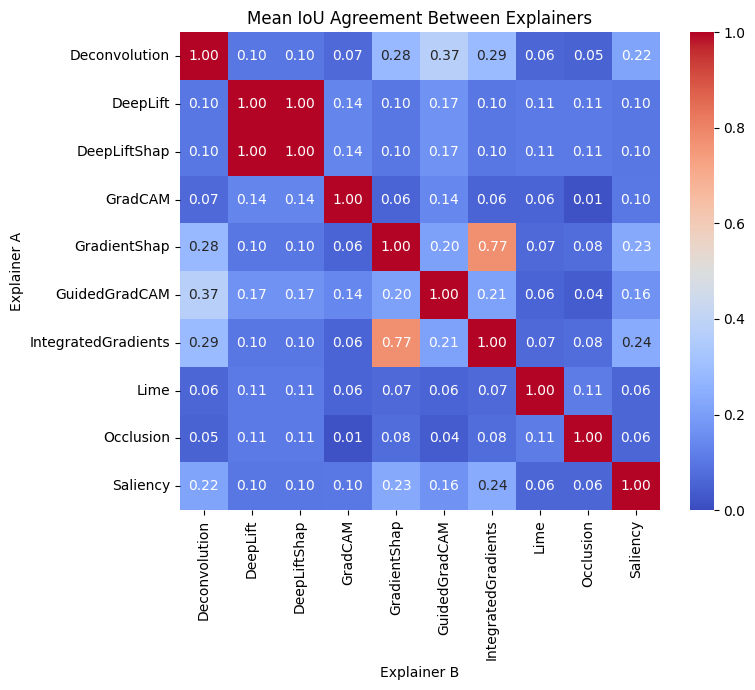

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# assumes `summary` as from summarize_pairwise_iou(agreements)
methods = sorted(set(summary["method_a"]).union(summary["method_b"]))
matrix = summary.pivot(index="method_a", columns="method_b", values="mean_iou").reindex(index=methods, columns=methods)

# mirror upper/lower triangles to fill the diagonal and lower half
matrix = matrix.combine_first(matrix.T)
np.fill_diagonal(matrix.values, 1.0)

plt.figure(figsize=(8, 7))
sns.heatmap(matrix, vmin=0, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Mean IoU Agreement Between Explainers")
plt.ylabel("Explainer A")
plt.xlabel("Explainer B")
plt.tight_layout()
plt.show()


# TCAV

In [48]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

from models import *
from dataloaders import PresetTransform

In [49]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):
    return PresetTransform("NCNN").transforms(img)

In [50]:
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    #img = Image.fromarray(np.array(img)[:, :, ::-1]) # VGG
    return transform(img)


def load_image_tensors(class_name, root_path='RGU\\TCAV\\concepts\\test images\\', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

In [51]:
def assemble_concept(name, id, concepts_path="RGU\\TCAV\\concepts"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

In [61]:
concepts_path = "RGU\\TCAV\\concepts"

#closed_eyes_concept = assemble_concept("closed eyes", 0, concepts_path=concepts_path)
#open_eyes_concept = assemble_concept("open eyes", 1, concepts_path=concepts_path)
#closed_mouth_concept = assemble_concept("closed mouth", 2, concepts_path=concepts_path)
#open_mouth_concept = assemble_concept("open mouth", 3, concepts_path=concepts_path)


#random_0_concept = assemble_concept("random_0", 4, concepts_path=concepts_path)
#random_1_concept = assemble_concept("random_1", 5, concepts_path=concepts_path)

#adult_concept = assemble_concept("adult", 6, concepts_path=concepts_path)
#child_concept = assemble_concept("child", 7, concepts_path=concepts_path)

NFCS_0_concept = assemble_concept("NFCS_0", 0, concepts_path=concepts_path)
NFCS_1_concept = assemble_concept("NFCS_1", 1, concepts_path=concepts_path)
NFCS_2_concept = assemble_concept("NFCS_2", 2, concepts_path=concepts_path)
NFCS_3_concept = assemble_concept("NFCS_3", 3, concepts_path=concepts_path)
NFCS_4_concept = assemble_concept("NFCS_4", 4, concepts_path=concepts_path)
NFCS_5_concept = assemble_concept("NFCS_5", 5, concepts_path=concepts_path)

n_figs = 10
n_concepts = 6

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([closed_eyes_concept, open_eyes_concept, closed_mouth_concept, open_mouth_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

In [ ]:
model = ViT()
model.load_state_dict(torch.load('experiments\\ViT_B_32\\20250718_1951_ViT\\Model\\best_model.pt'))
model.eval()

In [113]:
model = NCNN()
model.load_state_dict(torch.load('experiments\\NCNN_FINAL\\20250826_1349_NCNN\\Model\\best_model.pt'))
model.eval()

NCNN(
  (left_branch): Sequential(
    (0): MaxPool2d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
  )
  (center_branch): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (right_branch): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=10, stride=10, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
  )
  (merge_branch): Sequential(
    (0): Conv2d(131, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [84]:
model = VGGFace()
model.load_state_dict(torch.load('experiments\\VGGFace_FINAL\\20250826_1353_VGGFace\\Model\\best_model.pt'))
model.eval()

VGGFace(
  (VGGFace): VGG(
    (features): Sequential(
      (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_1): ReLU(inplace=True)
      (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_2): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_1): ReLU(inplace=True)
      (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_2): ReLU(inplace=True)
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_1): ReLU(inplace=True)
      (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_2): ReLU(inplace=True)
      (conv3_3): Conv2d(256, 256, kernel_size

In [114]:
layers=['merge_branch.0', 'left_branch.0', 'center_branch.3', 'right_branch.0']
#layers = ['ViT.encoder.layers.encoder_layer_11', 'ViT.encoder.layers.encoder_layer_1', 'ViT.encoder.layers.encoder_layer_6']
#layers = ['VGGFace.features.conv5_3']

mytcav = TCAV(model=model,
              layers=layers)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\concept\_core\tcav.py:325: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  self.classifier = DefaultClassifier()


In [63]:
experimental_set_rand = [[open_eyes_concept, closed_eyes_concept, open_mouth_concept, closed_mouth_concept], [open_mouth_concept, closed_mouth_concept, random_1_concept], [adult_concept, child_concept]]

In [64]:
experimental_set_rand = [[closed_eyes_concept, random_0_concept], [open_mouth_concept, random_0_concept], [child_concept, random_0_concept]]

In [115]:
experimental_set_rand = [[NFCS_0_concept, NFCS_5_concept]]

In [122]:
# Load sample images from folder
pain_imgs = load_image_tensors('pain', transform=False)

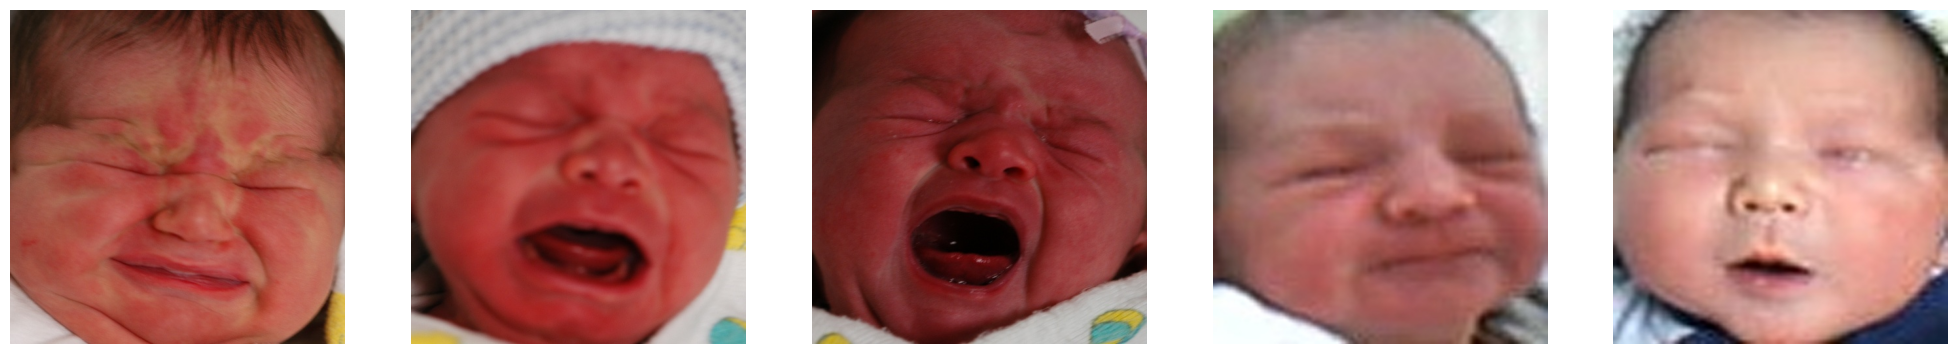

In [123]:
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(pain_imgs[0])
axs[1].imshow(pain_imgs[1])
axs[2].imshow(pain_imgs[2])
axs[3].imshow(pain_imgs[3])
axs[4].imshow(pain_imgs[4])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [124]:
# Load sample images from folder
pain_tensors = torch.stack([transform(img) for img in pain_imgs])
experimental_set_rand

[[Concept(0, 'NFCS_0'), Concept(5, 'NFCS_5')]]

In [125]:
tcav_scores_w_random = mytcav.interpret(inputs=pain_tensors,
                                        experimental_sets=experimental_set_rand,
                                        )
tcav_scores_w_random

defaultdict(<function captum.concept._core.tcav.TCAV.interpret.<locals>.<lambda>()>,
            {'0-5': defaultdict(None,
                         {'merge_branch.0': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.6834,  2.6834])},
                          'left_branch.0': {'sign_count': tensor([0.0417, 0.9583]),
                           'magnitude': tensor([-0.1601,  0.1601])},
                          'center_branch.3': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-1.8855,  1.8855])},
                          'right_branch.0': {'sign_count': tensor([0., 1.]),
                           'magnitude': tensor([-2.4098,  2.4098])}})})

In [126]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

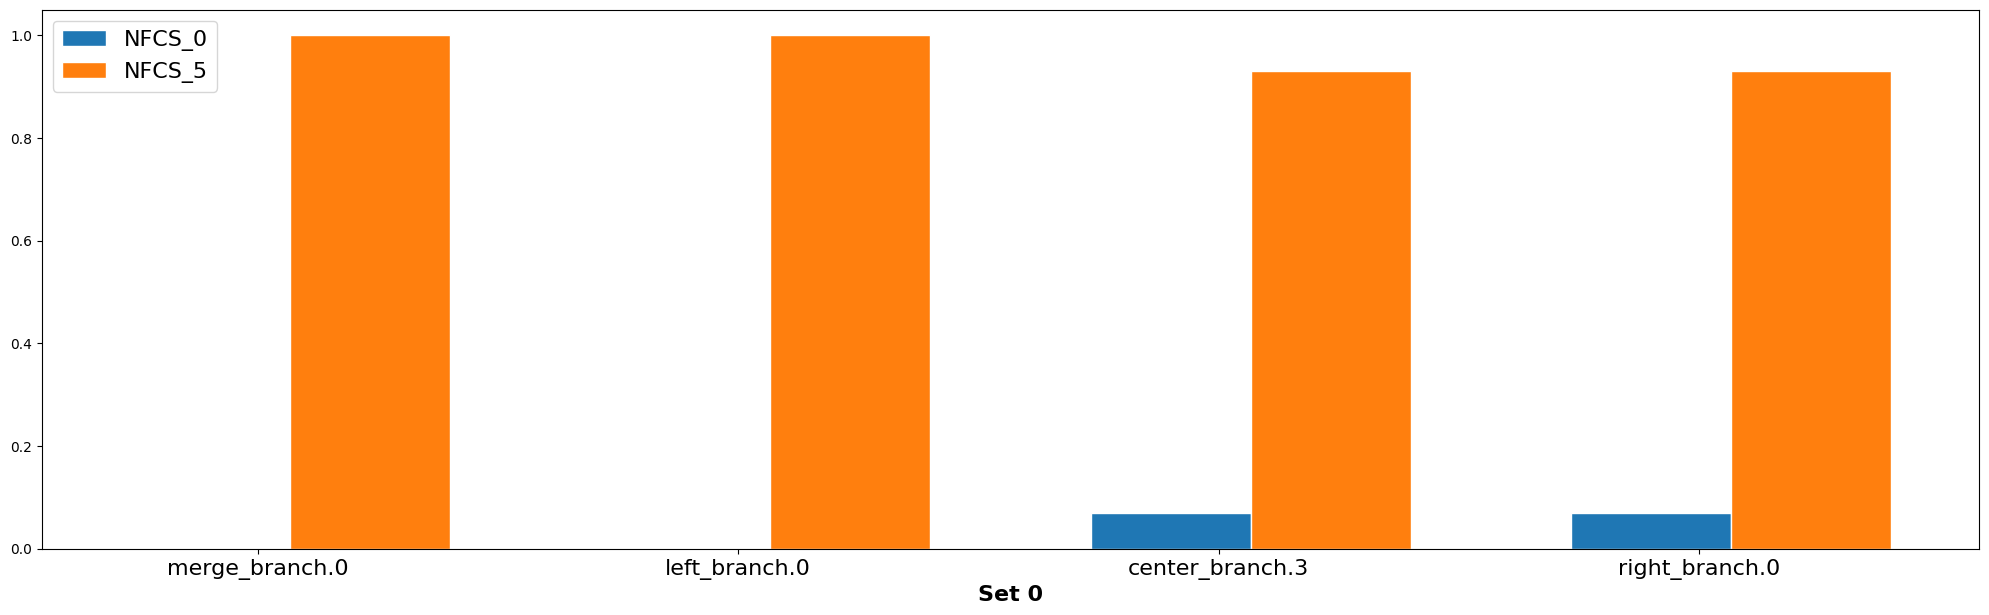

In [121]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

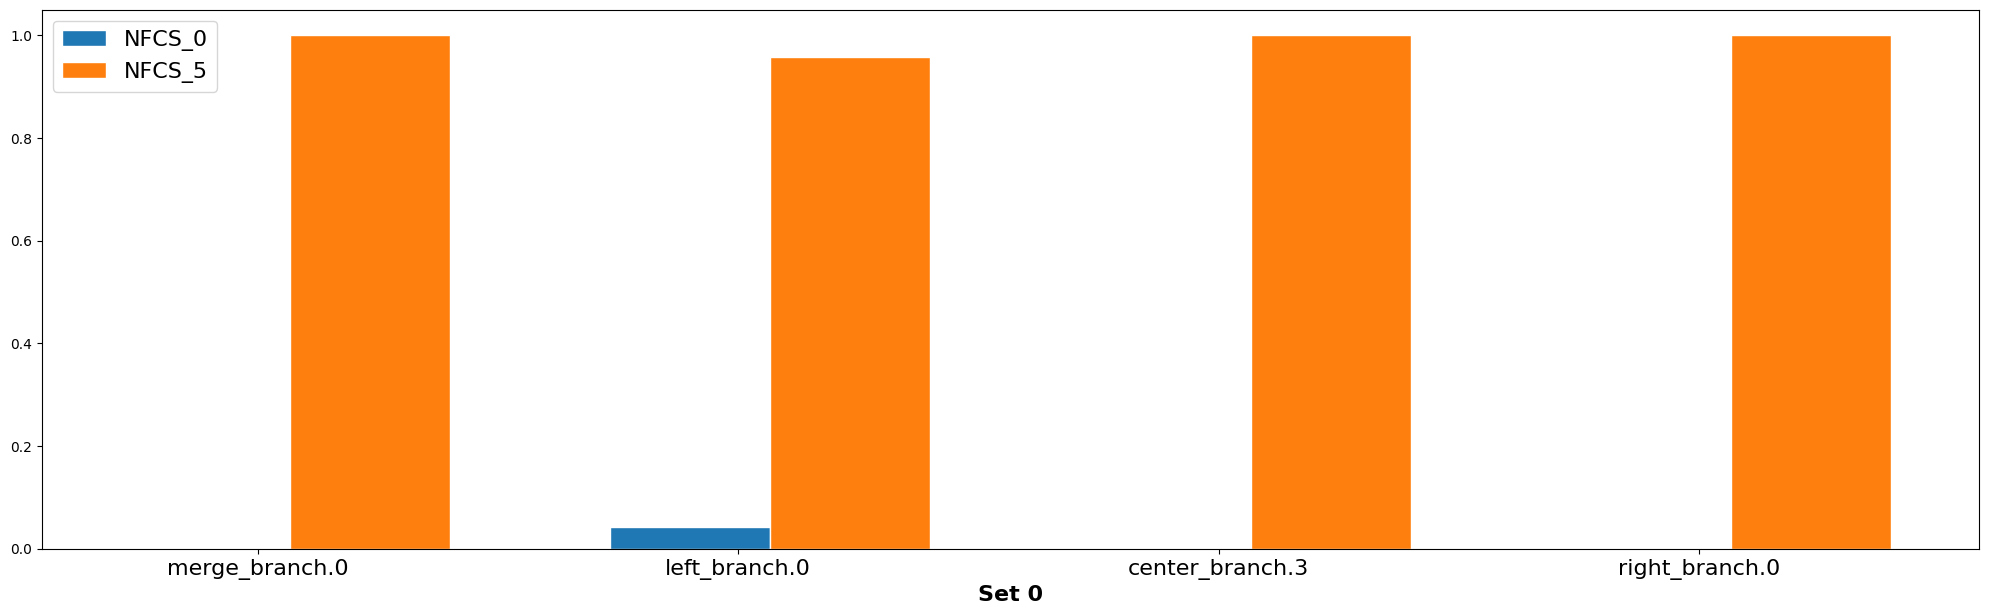

In [127]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)

In [15]:
n = 2

random_concepts = [assemble_concept('random_' + str(i+2), i+8) for i in range(0, n)]

print(random_concepts)

experimental_sets = [[open_eyes_concept, random_0_concept], [open_eyes_concept, random_1_concept]]
experimental_sets.extend([[open_eyes_concept, random_concept] for random_concept in random_concepts])

experimental_sets.append([random_0_concept, random_1_concept])
experimental_sets.extend([[random_0_concept, random_concept] for random_concept in random_concepts])

experimental_sets

[Concept(8, 'random_2'), Concept(9, 'random_3')]


[[Concept(1, 'open eyes'), Concept(4, 'random_0')],
 [Concept(1, 'open eyes'), Concept(5, 'random_1')],
 [Concept(1, 'open eyes'), Concept(8, 'random_2')],
 [Concept(1, 'open eyes'), Concept(9, 'random_3')],
 [Concept(4, 'random_0'), Concept(5, 'random_1')],
 [Concept(4, 'random_0'), Concept(8, 'random_2')],
 [Concept(4, 'random_0'), Concept(9, 'random_3')]]

In [16]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list

In [17]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation

In [18]:
scores = mytcav.interpret(pain_tensors, experimental_sets)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\_utils\models\linear_model\train.py:409: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


In [19]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

In [ ]:
show_boxplots("ViT.encoder")

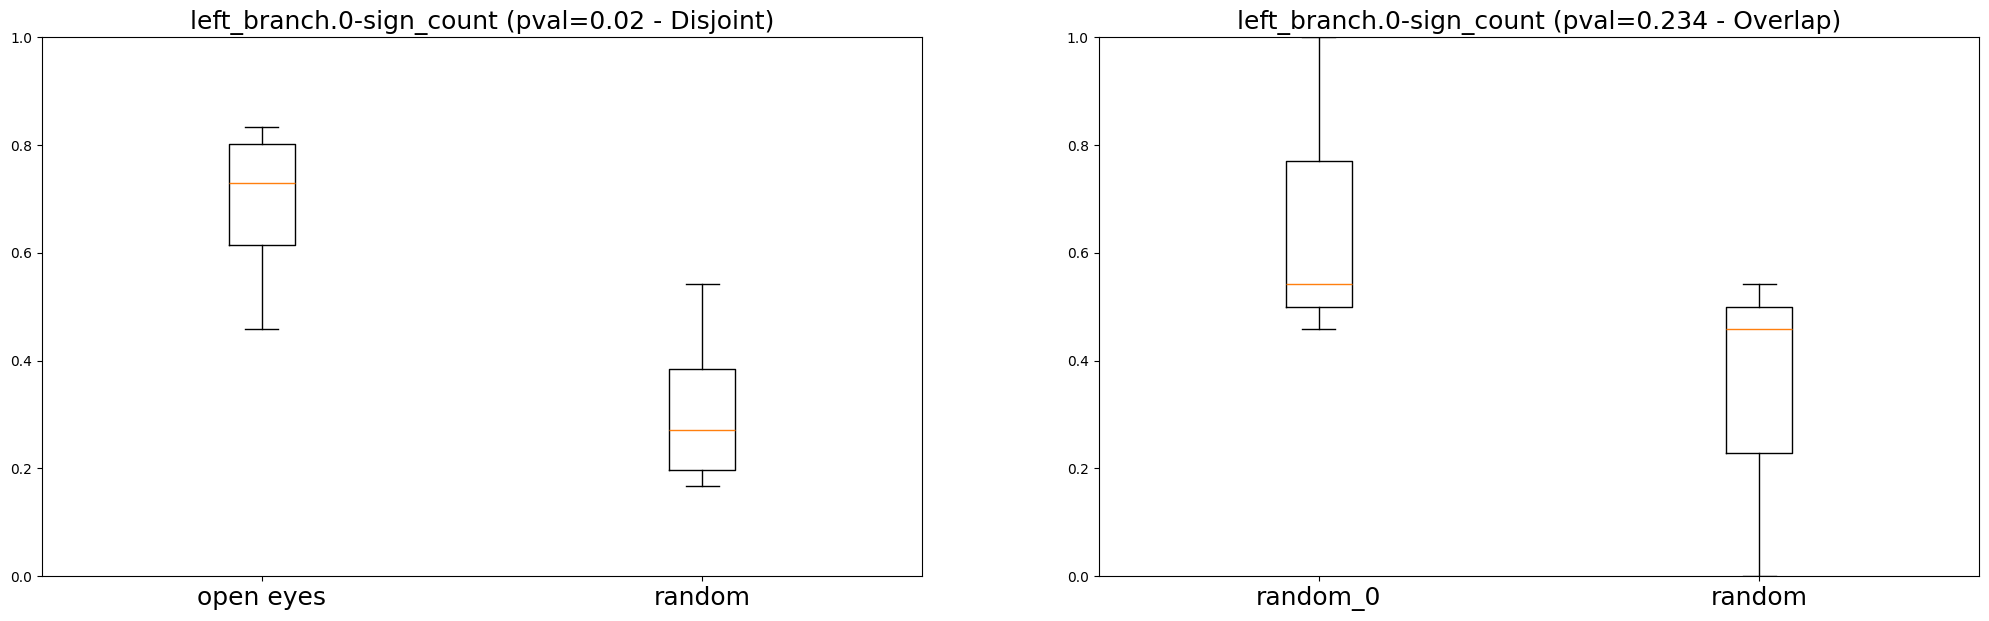

In [21]:
show_boxplots("left_branch.0")

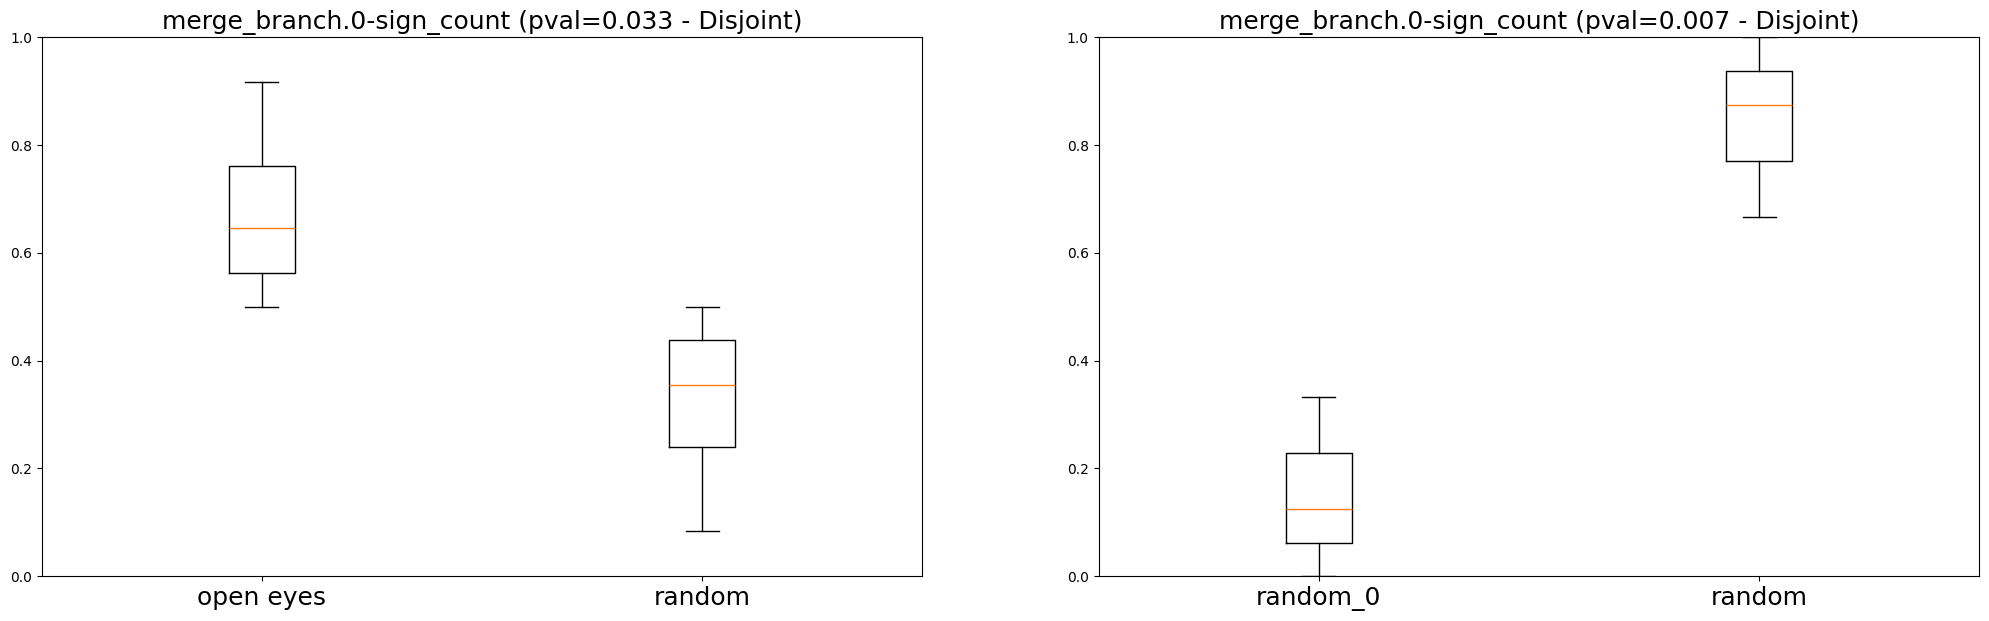

In [24]:
show_boxplots("merge_branch.0")

In [ ]:
show_boxplots("right_branch")

In [46]:
import pandas as pd
import shutil

In [36]:
df = pd.read_csv('iCOPE+UNIFESP_data.csv')

In [40]:
NFCS_df = df[~df['NFCS'].isna()]

NFCS_df.head()

file_name subject gender   class  dataset  \
288  Datasets\Originais\UNIFESP\01_113607.bmp      01    NaN  nopain  UNIFESP   
289  Datasets\Originais\UNIFESP\01_113814.bmp      01    NaN  nopain  UNIFESP   
290  Datasets\Originais\UNIFESP\01_114056.bmp      01    NaN  nopain  UNIFESP   
291  Datasets\Originais\UNIFESP\01_113538.bmp      01    NaN    pain  UNIFESP   
292  Datasets\Originais\UNIFESP\01_113719.bmp      01    NaN    pain  UNIFESP   

     NFCS new_subject                 new_file_name     face_coordinates  \
288   0.0         S27  ID288_UNIFESP_S27_nopain.jpg  [137, 59, 224, 157]   
289   4.0         S27  ID289_UNIFESP_S27_nopain.jpg  [102, 41, 227, 178]   
290   2.0         S27  ID290_UNIFESP_S27_nopain.jpg  [120, 61, 209, 160]   
291   3.0         S27    ID291_UNIFESP_S27_pain.jpg  [152, 39, 244, 143]   
292   4.0         S27    ID292_UNIFESP_S27_pain.jpg  [127, 61, 220, 161]   

                                 keypoints_coordinates  
288  [[163, 113], [204, 105], [190, 127], [177, 142...  
289  [[138, 114], [194, 99], [175, 130], [155, 155]...  
290  [[137, 113], [176, 104], [155, 125], [147, 144...  
291  [[182, 83], [223, 91], [202, 103], [179, 116],...  
292  [[146, 112], [185, 102], [167, 127], [159, 141...

In [47]:
for i, row in NFCS_df.iterrows():

    NFCS = int(row['NFCS'])
    img_name = row['new_file_name']

    path_from = os.path.join('Datasets\\DatasetFaces\\Images', img_name)

    path_to = os.path.join('RGU\\TCAV\\concepts\\',f"NFCS_{NFCS}",img_name)

    shutil.copy(path_from, path_to)


In [45]:
img_name

'ID644_UNIFESP_S30_pain.jpg'

# LIME With Facial Features

In [ ]:
from captum.attr import Lime
from XAI.metrics import  create_face_regions_masks
import pickle
from utils import resize_landmarks
import cv2
import torch
from captum.attr import visualization as viz


In [ ]:
with open(f'Datasets/DatasetFaces/Landmarks/{id}.pkl', 'rb') as f:
    landmarks = pickle.load(f)

test = create_face_regions_masks(landmarks)

test['eyes'] = test['right_eye'] + test['left_eye']
test['eyebrown'] = test['right_eyebrown'] + test['left_eyebrown']
test['nasolabial_fold'] = test['right_nasolabial_fold'] + test['left_nasolabial_fold']
test['cheek'] = test['right_cheek'] + test['left_cheek']

test.pop('right_eye')
test.pop('left_eye')
test.pop('right_eyebrown')
test.pop('left_eyebrown')
test.pop('right_nasolabial_fold')
test.pop('left_nasolabial_fold')
test.pop('right_cheek')
test.pop('left_cheek')
test.pop('outside')

features = np.zeros((img_size,img_size))

for i,mask in enumerate(test):
    features[np.where(cv2.resize(test[mask], (img_size,img_size), interpolation=cv2.INTER_NEAREST) == 1)] = i

features = np.stack([features] * 3, axis=0)

In [ ]:
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso


In [ ]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

def iter_combinations(*args, **kwargs):
    for i in range(2 **  len(test)):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill( len(test))]).unsqueeze(0)


lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLasso(alpha=0.08),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)


attrs = lr_lime.attribute(
    img_transformed,
    feature_mask=torch.tensor(features, dtype=torch.int64),
    n_samples=2 ** len(test),
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

In [ ]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs.cpu().detach())

# RISE

In [ ]:
from XAI import RISE
from models import NCNN, VGGFace
import torch
from dataloaders import presets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = "cuda"

In [ ]:
rise = RISE(model, input_size=(224,224), gpu_batch=10, device=device)

rise.generate_masks(1000, 8, 0.1)

In [ ]:
plt.imshow(rise.masks[0].cpu()[0])

In [ ]:
model.predict(img_transformed.unsqueeze(0).to(device))

In [ ]:
plt.imshow(mask.cpu())
plt.imshow(img.resize((224,224)), alpha=0.5)